# Fully Convolutional Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import sys
sys.path.insert(0,"/home/snn/deepcell-tf")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import deepcell

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell import losses
import image_gen as image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool3D
from conv_gru_layer import ConvGRU2D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten, Reshape
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

### Load the Training Data

In [145]:
# If DATA_FILE exists just run this cell

from deepcell.utils.data_utils import get_data

DATA_DIR = '/data/npz_data/tracking_benchmark_data'
# DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V2_stacked.npz')
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V2.npz')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

KeyboardInterrupt: 

### Set up filepath constants

In [3]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

NameError: name 'DATA_FILE' is not defined

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [4]:
def feature_net_3D(receptive_field=61,
                    n_frames=3,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    gru_kernel_size =3,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='whole_image',
                    gru=False,
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    win_z = (n_frames - 1) // 2

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method, filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))([-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    if multires:
        layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    append_gru = False
    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        if append_gru == True:
            x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=(filter_size, filter_size), dilation_rate=(d, d),
                            padding='valid', kernel_initializer=init,
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        else:
            x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size), 
                            dilation_rate=(1, d, d), kernel_initializer=init,
                            padding='valid', kernel_regularizer=l2(reg))(x[-1]))

        
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d), pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))
        
    
    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))
    
    if gru is True:
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=gru_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        # x.append(Activation('relu')(x[-1]))
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=gru_kernel_size+2,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        # x.append(Activation('relu')(x[-1]))
    
    
    x.append(TensorProduct(n_dense_filters, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])
    model.summary()

    return model

In [5]:
def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        gru=False,
                        gru_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    # print(K.image_data_format())
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    inputs = Input(shape=input_shape)
    
    img = ImageNormalization3D(norm_method=norm_method,
                               filter_size=receptive_field)(inputs)

    models = []
    model_outputs = []

    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img
        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, norm_method=None, dilated=True, 
                                     padding=True, padding_mode=padding_mode, gru=gru, 
                                     gru_kernel_size=gru_kernel_size, **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    else:
        if fgbg_model is None:
            model = Model(inputs=inputs, outputs=model_outputs)
        else:
            model = Model(inputs=inputs, outputs=model_outputs[1:])
    model.summary()
    return model

#### Test Generator

In [151]:
DataGenerator = image_generators.MovieDataGenerator

datagen = DataGenerator(
    rotation_range=180,
    shear_range=False,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = DataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)


train_data = datagen.flow(
    train_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

val_data = datagen_val.flow(
    test_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

(642, 30, 135, 160, 1)
Image number: 344
Frame number: 14


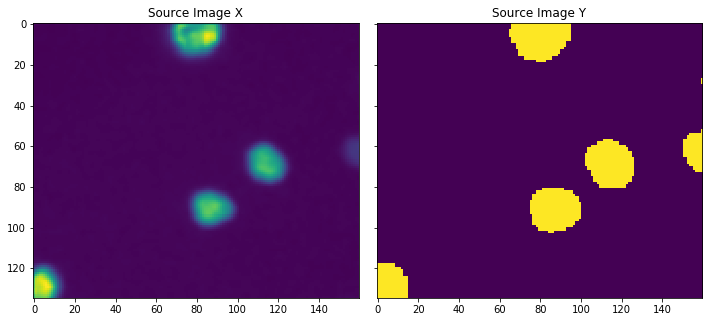

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_data.x.shape)

index = np.random.randint(low=0, high=train_data.x.shape[0])
frame = np.random.randint(low=0, high=train_data.x.shape[1])
print('Image number:', index)
print('Frame number:', frame)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(train_data.x[index, frame, ..., 0])
ax[0].set_title('Source Image X')

ax[1].imshow(train_data.y[index, frame, ..., 1])
ax[1].set_title('Source Image Y')

fig.tight_layout()
plt.show()

#### (1) Function to create the model fgbg model

In [9]:
def create_and_train_fgbg(lr_sched, train_dict, test_dict, fgbg_gru_model_name, gru_kernel_size=3, gru=False):
    
    fgbg_model = feature_net_skip_3D(
                    n_features=2,  # segmentation mask (is_cell, is_not_cell)
                    receptive_field=receptive_field,
                    n_skips=n_skips,
                    n_conv_filters=32,
                    n_dense_filters=128,
                    gru=gru,
                    gru_kernel_size=gru_kernel_size,
                    input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
                    last_only=False)

    print("Training fgbg model. \n")

    fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_gru_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

    # Save model
    fgbg_gru_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_gru_model_name))
    fgbg_model.save_weights(fgbg_gru_weights_file)

    return fgbg_model

### Next, Create a model for the watershed energy transform

### Function to create the distance transform model

In [40]:
def create_and_train_gru(fgbg_model, lr_sched, train_dict, test_dict, conv_gru_model_name, gru_kernel_size=3, gru=False):
    
    conv_gru_model = feature_net_skip_3D(
        fgbg_model=fgbg_model,
        receptive_field=receptive_field,
        n_skips=n_skips,
        n_features=4,  # (background edge, interior edge, cell interior, background)
        n_frames=frames_per_batch,
        n_conv_filters=32,
        n_dense_filters=128,
        gru=gru,
        gru_kernel_size=gru_kernel_size,
        multires=False,
        last_only=False,
        input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
        norm_method=norm_method)

    print("Training segmentation model. \n")

    conv_gru_model = train_model_conv(
        model=conv_gru_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_gru_model_name,
        log_dir=LOG_DIR,
        optimizer=optimizer,
        transform='watershed', #'deepcell_flat', 
        dilation_radius=1,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))
    
    # Save model
    conv_gru_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_gru_model_name))
    conv_gru_model.save_weights(conv_gru_weights_file)

# Train the models

### Training settings

In [6]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'trackingSEG_cropped_conv_gru_fgbg_model_3'
conv_model_name = 'trackingSEG_cropped_conv_gru_watershed_model_33'

n_epoch = 10  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch
frames_per_batch = 3

# Transformation settings
transform = 'watershed'
distance_bins = 4
erosion_width = 1  # erode edges

### (1) Train fgbg model

In [12]:
fgbg_model =  create_and_train_fgbg(lr_sched, train_dict, test_dict, fgbg_model_name, gru_kernel_size=3, gru=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 135, 160, 1)    0         
_________________________________________________________________
image_normalization3d_1 (Ima (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 5, 195, 220, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 5, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 192, 217, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 5, 192, 217, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 190, 215, 32)   9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 135, 160, 3)    0         
_________________________________________________________________
image_normalization3d_3 (Ima (None, 3, 135, 160, 3)    0         
_________________________________________________________________
reflection_padding3d_2 (Refl (None, 5, 195, 220, 3)    0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 5, 192, 217, 32)   1568      
_________________________________________________________________
batch_normalization_20 (Batc (None, 5, 192, 217, 32)   128       
_________________________________________________________________
activation_18 (Activation)   (None, 5, 192, 217, 32)   0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 5, 190, 215, 32)   9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d (ImageNor (None, 3, 135, 160,  0           input_1[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 3, 135, 160,  306978      image_normalization3d[0][0]      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3, 135, 160,  0           image_normalization3d[0][0]      
                                                                 model[1][0]                      
__________

Epoch 8/10
320/321 [============================>.] - ETA: 0s - loss: 0.7683 - model_loss: 0.1903 - model_1_loss: 0.1754 - model_2_loss: 0.1748 - model_3_loss: 0.1729 - model_acc: 0.9621 - model_1_acc: 0.9647 - model_2_acc: 0.9644 - model_3_acc: 0.9647
Epoch 00008: val_loss improved from 0.84785 to 0.84314, saving model to /data/models/trackingSEG_cropped_conv_gru_fgbg_model_3.h5
321/321 [==============================] - 240s 749ms/step - loss: 0.7676 - model_loss: 0.1902 - model_1_loss: 0.1753 - model_2_loss: 0.1746 - model_3_loss: 0.1728 - model_acc: 0.9622 - model_1_acc: 0.9647 - model_2_acc: 0.9644 - model_3_acc: 0.9648 - val_loss: 0.8431 - val_model_loss: 0.1995 - val_model_1_loss: 0.1906 - val_model_2_loss: 0.2082 - val_model_3_loss: 0.1900 - val_model_acc: 0.9685 - val_model_1_acc: 0.9689 - val_model_2_acc: 0.9689 - val_model_3_acc: 0.9638
Epoch 9/10
320/321 [============================>.] - ETA: 0s - loss: 0.7523 - model_loss: 0.1803 - model_1_loss: 0.1771 - model_2_loss: 0.1

In [76]:
watershed_model =  create_and_train_gru(fgbg_model, lr_sched, 
                                        train_dict, test_dict, 
                                        conv_model_name, gru_kernel_size=3, 
                                        gru=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        (None, 3, 135, 160, 3)    0         
_________________________________________________________________
image_normalization3d_81 (Im (None, 3, 135, 160, 3)    0         
_________________________________________________________________
reflection_padding3d_64 (Ref (None, 5, 195, 220, 3)    0         
_________________________________________________________________
conv3d_512 (Conv3D)          (None, 5, 192, 217, 32)   1568      
_________________________________________________________________
batch_normalization_644 (Bat (None, 5, 192, 217, 32)   128       
_________________________________________________________________
activation_576 (Activation)  (None, 5, 192, 217, 32)   0         
_________________________________________________________________
conv3d_513 (Conv3D)          (None, 5, 190, 215, 32)   9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        (None, 3, 135, 160, 5)    0         
_________________________________________________________________
image_normalization3d_83 (Im (None, 3, 135, 160, 5)    0         
_________________________________________________________________
reflection_padding3d_66 (Ref (None, 5, 195, 220, 5)    0         
_________________________________________________________________
conv3d_528 (Conv3D)          (None, 5, 192, 217, 32)   2592      
_________________________________________________________________
batch_normalization_666 (Bat (None, 5, 192, 217, 32)   128       
_________________________________________________________________
activation_594 (Activation)  (None, 5, 192, 217, 32)   0         
_________________________________________________________________
conv3d_529 (Conv3D)          (None, 5, 190, 215, 32)   9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_80 (Image (None, 3, 135, 160,  0           input_81[0][0]                   
__________________________________________________________________________________________________
model_83 (Model)                multiple             1846280     input_81[0][0]                   
__________________________________________________________________________________________________
concatenate_50 (Concatenate)    (None, 3, 135, 160,  0           image_normalization3d_80[0][0]   
                                                                 model_83[1][3]                   
__________

Epoch 7/10
320/321 [============================>.] - ETA: 2s - loss: 5.0148 - model_84_loss: 1.2536 - model_85_loss: 1.2165 - model_86_loss: 1.2099 - model_87_loss: 1.2012 - model_84_acc: 0.8798 - model_85_acc: 0.8816 - model_86_acc: 0.8824 - model_87_acc: 0.8833
Epoch 00007: val_loss did not improve from 4.51631
321/321 [==============================] - 948s 3s/step - loss: 5.0147 - model_84_loss: 1.2536 - model_85_loss: 1.2165 - model_86_loss: 1.2099 - model_87_loss: 1.2012 - model_84_acc: 0.8798 - model_85_acc: 0.8816 - model_86_acc: 0.8824 - model_87_acc: 0.8833 - val_loss: 4.6307 - val_model_84_loss: 1.1993 - val_model_85_loss: 1.1123 - val_model_86_loss: 1.1022 - val_model_87_loss: 1.0833 - val_model_84_acc: 0.9040 - val_model_85_acc: 0.8937 - val_model_86_acc: 0.8886 - val_model_87_acc: 0.8952
Epoch 8/10
320/321 [============================>.] - ETA: 2s - loss: 5.0580 - model_84_loss: 1.2577 - model_85_loss: 1.2350 - model_86_loss: 1.2204 - model_87_loss: 1.2113 - model_84_ac

### Run the model

#### Make predictions on test data

In [ ]:
fgbg_model = feature_net_skip_3D(
        receptive_field=receptive_field,
        n_features=2,
        n_frames=frames_per_batch,
        n_skips=n_skips,
        n_conv_filters=32,
        n_dense_filters=128,
        input_shape=tuple(X_test.shape[1:]),
        gru=True,
        gru_kernel_size=3,
        multires=False,
        last_only=False,
        norm_method=norm_method)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

In [ ]:
watershed_model = feature_net_skip_3D(
        fgbg_model=fgbg_model,
        receptive_field=receptive_field,
        n_skips=n_skips,
        n_features=4,  # (background edge, interior edge, cell interior, background)
        n_frames=frames_per_batch,
        n_conv_filters=32,
        n_dense_filters=128,
        gru=True,
        gru_kernel_size=3,
        multires=False,
        last_only=False,
        input_shape=tuple(X_test.shape[1:]),
        norm_method=norm_method)

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model_33.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_207 (InputLayer)       (None, 30, 202, 240, 1)   0         
_________________________________________________________________
image_normalization3d_206 (I (None, 30, 202, 240, 1)   0         
_________________________________________________________________
reflection_padding3d_164 (Re (None, 32, 262, 300, 1)   0         
_________________________________________________________________
conv3d_1312 (Conv3D)         (None, 32, 259, 297, 32)  544       
_________________________________________________________________
batch_normalization_1744 (Ba (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_1476 (Activation) (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_1313 (Conv3D)         (None, 32, 257, 295, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_209 (InputLayer)       (None, 30, 202, 240, 3)   0         
_________________________________________________________________
image_normalization3d_208 (I (None, 30, 202, 240, 3)   0         
_________________________________________________________________
reflection_padding3d_166 (Re (None, 32, 262, 300, 3)   0         
_________________________________________________________________
conv3d_1328 (Conv3D)         (None, 32, 259, 297, 32)  1568      
_________________________________________________________________
batch_normalization_1766 (Ba (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_1494 (Activation) (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_1329 (Conv3D)         (None, 32, 257, 295, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_206 (InputLayer)          (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_205 (Imag (None, 30, 202, 240, 0           input_206[0][0]                  
__________________________________________________________________________________________________
model_210 (Model)               (None, 30, 202, 240, 460802      image_normalization3d_205[0][0]  
__________________________________________________________________________________________________
concatenate_135 (Concatenate)   (None, 30, 202, 240, 0           image_normalization3d_205[0][0]  
                                                                 model_210[1][0]                  
__________

In [100]:
# make predictions on testing data
test_images = watershed_model.predict(X_test[:6, :, :, :, :])[-1]
test_images_fgbg = fgbg_model.predict(X_test[:6, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (6, 30, 135, 160, 4)
segmentation mask shape: (6, 30, 135, 160, 2)


### Watershed post-processing

In [101]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (6, 30, 135, 160, 1)


In [108]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.9
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [125]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = remove_small_objects(watershed_images[:, :, :, :].astype('uint16'), min_size=400)
watershed_images = np.expand_dims(watershed_images, axis=-1)


### Plot the Results

Image number: 0
Frame: 21


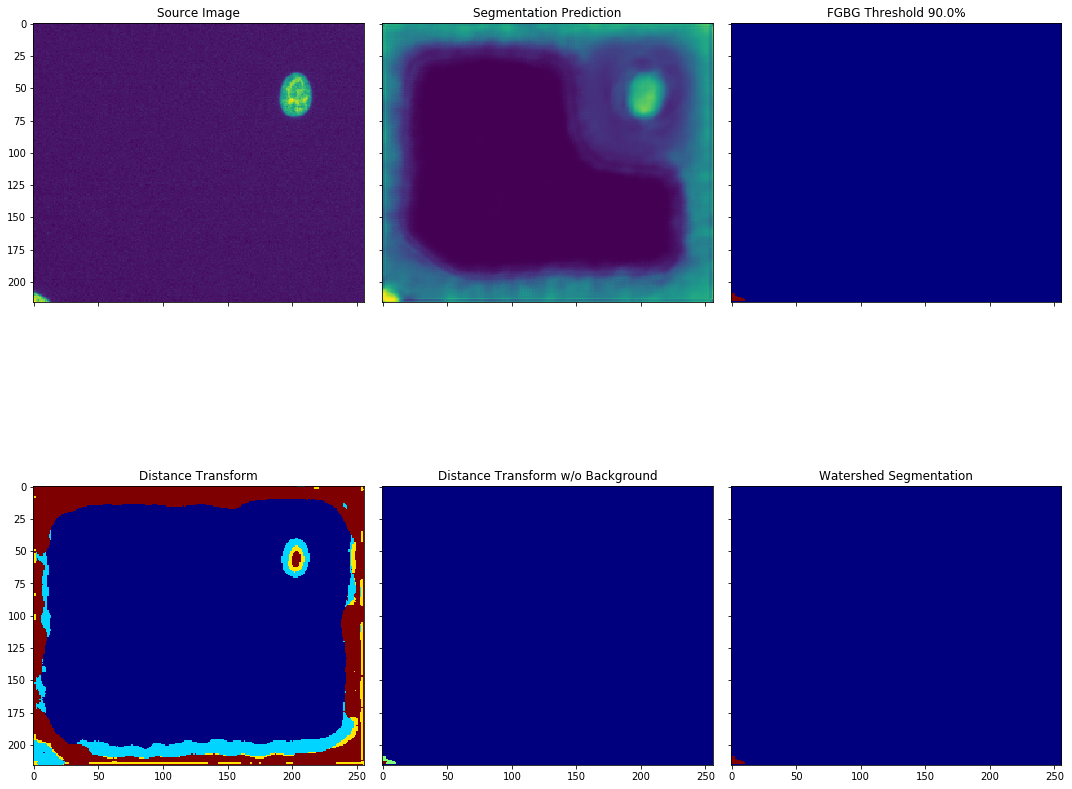

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 5 #np.random.randint(low=0, high=6)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)


fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[3].set_title('Distance Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Run the Model Iteratively

In [137]:
# Define the Datasets

###### For Deepcell Datasets

# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa, raw_trks_RAW]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [140]:
# Instantiate new models for any image size

from deepcell import model_zoo

def test_gru(X_test):
    fgbg_model = feature_net_skip_3D(
            receptive_field=receptive_field,
            n_features=2,
            n_frames=frames_per_batch,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            input_shape=tuple(X_test.shape[1:]),
            gru=True,
            gru_kernel_size=3,
            multires=False,
            last_only=False,
            norm_method=norm_method)

    fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')


    watershed_model = feature_net_skip_3D(
            fgbg_model=fgbg_model,
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_features=4,  # (background edge, interior edge, cell interior, background)
            n_frames=frames_per_batch,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=True,
            gru_kernel_size=3,
            multires=False,
            last_only=False,
            input_shape=tuple(X_test.shape[1:]),
            norm_method=norm_method)

    watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model_33.h5')
    
    fgbg_model = feature_net_skip_3D(
            receptive_field=receptive_field,
            n_features=2,
            n_frames=frames_per_batch,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            input_shape=tuple(X_test.shape[1:]),
            gru=True,
            gru_kernel_size=3,
            multires=False,
            last_only=False,
            norm_method=norm_method)

    fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

    return fgbg_model, watershed_model

In [141]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa']
CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa', 'RAW264']

# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.5
Lstats_AllDatasets = []
# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    fgbg_model, watershed_model = test_gru(trks['X'])
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
    Lstats = []
    # Go through each batch (movie) in each dataset
    # Predict on the raw data
    for j in range(len(trks['y'])):
        X_test, y_test = trks['X'][j:j+1, ...], trks['y'][j:j+1,...]
        print("X_test.shape", X_test.shape)
        test_images = watershed_model.predict(X_test)[-1]
        test_images_fgbg = fgbg_model.predict(X_test)[-1]
        # Postprocessing
        # Collapse predictions into semantic segmentation mask
        argmax_images = []
        for i in range(test_images.shape[0]):
            max_image = np.argmax(test_images[i], axis=-1)
            argmax_images.append(max_image)
        argmax_images = np.array(argmax_images)
        argmax_images = np.expand_dims(argmax_images, axis=-1)
        # threshold the foreground/background
        # and remove background from watershed transform
        fg_thresh = test_images_fgbg[..., 1] > threshold
        fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
        argmax_images_post_fgbg = argmax_images * fg_thresh
        watershed_images = []
        for i in range(argmax_images_post_fgbg.shape[0]):
            image = fg_thresh[i, ..., 0]
            distance = argmax_images_post_fgbg[i, ..., 0]
            local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)
            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_images.append(segments)
        watershed_images = np.array(watershed_images)
        watershed_images = np.expand_dims(watershed_images, axis=-1)
        print("watershed_images.shape", watershed_images.shape)
        # Accuracy from metrics package
        batch_num = j
        filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
        # Remove small objects from GT for comparison
        small_objects_threshold=100        
        GT_image = remove_small_objects(tracked[j:j+1, :, :, :, 0].astype('uint16'), min_size=small_objects_threshold)
        print("GT_image.shape", GT_image.shape)
        #GT_image = tracked[batch_num, :, :, :, :].astype('uint16')
        m = metrics.Metrics(model_name = filename)
        m.calc_object_stats(GT_image, watershed_images[:,:,:,:, 0])
        #m.save_to_json(m.output)    
        Lstats.append(m.stats)                
    Lstats_AllDatasets.append(Lstats)
df_3T3    = pd.concat(Lstats_AllDatasets[0]) 
df_HEK293 = pd.concat(Lstats_AllDatasets[1])
df_HeLa   = pd.concat(Lstats_AllDatasets[2])
df_RAW264 = pd.concat(Lstats_AllDatasets[3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_147 (InputLayer)       (None, 30, 154, 182, 1)   0         
_________________________________________________________________
image_normalization3d_146 (I (None, 30, 154, 182, 1)   0         
_________________________________________________________________
reflection_padding3d_116 (Re (None, 32, 214, 242, 1)   0         
_________________________________________________________________
conv3d_928 (Conv3D)          (None, 32, 211, 239, 32)  544       
_________________________________________________________________
batch_normalization_1216 (Ba (None, 32, 211, 239, 32)  128       
_________________________________________________________________
activation_1044 (Activation) (None, 32, 211, 239, 32)  0         
_________________________________________________________________
conv3d_929 (Conv3D)          (None, 32, 209, 237, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_149 (InputLayer)       (None, 30, 154, 182, 3)   0         
_________________________________________________________________
image_normalization3d_148 (I (None, 30, 154, 182, 3)   0         
_________________________________________________________________
reflection_padding3d_118 (Re (None, 32, 214, 242, 3)   0         
_________________________________________________________________
conv3d_944 (Conv3D)          (None, 32, 211, 239, 32)  1568      
_________________________________________________________________
batch_normalization_1238 (Ba (None, 32, 211, 239, 32)  128       
_________________________________________________________________
activation_1062 (Activation) (None, 32, 211, 239, 32)  0         
_________________________________________________________________
conv3d_945 (Conv3D)          (None, 32, 209, 237, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_146 (InputLayer)          (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_145 (Imag (None, 30, 154, 182, 0           input_146[0][0]                  
__________________________________________________________________________________________________
model_150 (Model)               (None, 30, 154, 182, 460802      image_normalization3d_145[0][0]  
__________________________________________________________________________________________________
concatenate_95 (Concatenate)    (None, 30, 154, 182, 0           image_normalization3d_145[0][0]  
                                                                 model_150[1][0]                  
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_154 (InputLayer)       (None, 30, 154, 182, 5)   0         
_________________________________________________________________
image_normalization3d_153 (I (None, 30, 154, 182, 5)   0         
_________________________________________________________________
reflection_padding3d_122 (Re (None, 32, 214, 242, 5)   0         
_________________________________________________________________
conv3d_976 (Conv3D)          (None, 32, 211, 239, 32)  2592      
_________________________________________________________________
batch_normalization_1282 (Ba (None, 32, 211, 239, 32)  128       
_________________________________________________________________
activation_1098 (Activation) (None, 32, 211, 239, 32)  0         
_________________________________________________________________
conv3d_977 (Conv3D)          (None, 32, 209, 237, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_151 (InputLayer)          (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_150 (Imag (None, 30, 154, 182, 0           input_151[0][0]                  
__________________________________________________________________________________________________
model_154 (Model)               [(None, 30, 154, 182 1846280     input_151[0][0]                  
__________________________________________________________________________________________________
concatenate_98 (Concatenate)    (None, 30, 154, 182, 0           image_normalization3d_150[0][0]  
                                                                 model_154[1][3]                  
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_158 (InputLayer)       (None, 30, 154, 182, 3)   0         
_________________________________________________________________
image_normalization3d_157 (I (None, 30, 154, 182, 3)   0         
_________________________________________________________________
reflection_padding3d_125 (Re (None, 32, 214, 242, 3)   0         
_________________________________________________________________
conv3d_1000 (Conv3D)         (None, 32, 211, 239, 32)  1568      
_________________________________________________________________
batch_normalization_1315 (Ba (None, 32, 211, 239, 32)  128       
_________________________________________________________________
activation_1125 (Activation) (None, 32, 211, 239, 32)  0         
_________________________________________________________________
conv3d_1001 (Conv3D)         (None, 32, 209, 237, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_160 (InputLayer)       (None, 30, 154, 182, 3)   0         
_________________________________________________________________
image_normalization3d_159 (I (None, 30, 154, 182, 3)   0         
_________________________________________________________________
reflection_padding3d_127 (Re (None, 32, 214, 242, 3)   0         
_________________________________________________________________
conv3d_1016 (Conv3D)         (None, 32, 211, 239, 32)  1568      
_________________________________________________________________
batch_normalization_1337 (Ba (None, 32, 211, 239, 32)  128       
_________________________________________________________________
activation_1143 (Activation) (None, 32, 211, 239, 32)  0         
_________________________________________________________________
conv3d_1017 (Conv3D)         (None, 32, 209, 237, 32)  9248      
__________

watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 19

Correct detections:  1	Recall: 12.5%
Incorrect detections: 18	Precision: 5.26315789473684247923301882110536098480224609375%

Gained detections: 18	Perc Error: 72%
Missed detections: 7	Perc Error: 28%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81296503648053164425846262020058929920196533203125 

X_test.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted


____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 19

Correct detections:  1	Recall: 7.69230769230769251265655839233659207820892333984375%
Incorrect detections: 18	Precision: 5.26315789473684247923301882110536098480224609375%

Gained detections: 16	Perc Error: 57.14285714285714590232601040042936801910400390625%
Missed detections: 11	Perc Error: 39.28571428571428469922466319985687732696533203125%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 3.571428571428571618895375650026835501194000244140625%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84876797108429624660885792764020152390003204345703125 

X_test.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

_______

watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 13

Correct detections:  3	Recall: 27.27272727272727337322066887281835079193115234375%
Incorrect detections: 10	Precision: 23.076923076923076649791255476884543895721435546875%

Gained detections: 10	Perc Error: 55.5555555555555571345394128002226352691650390625%
Missed detections: 8	Perc Error: 44.4444444444444428654605871997773647308349609375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8729965145183971042541770657408051192760467529296875 

X_test.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_163 (InputLayer)       (None, 30, 135, 160, 3)   0         
_________________________________________________________________
image_normalization3d_162 (I (None, 30, 135, 160, 3)   0         
_________________________________________________________________
reflection_padding3d_129 (Re (None, 32, 195, 220, 3)   0         
_________________________________________________________________
conv3d_1032 (Conv3D)         (None, 32, 192, 217, 32)  1568      
_________________________________________________________________
batch_normalization_1359 (Ba (None, 32, 192, 217, 32)  128       
_________________________________________________________________
activation_1161 (Activation) (None, 32, 192, 217, 32)  0         
_________________________________________________________________
conv3d_1033 (Conv3D)         (None, 32, 190, 215, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       (None, 30, 135, 160, 3)   0         
_________________________________________________________________
image_normalization3d_164 (I (None, 30, 135, 160, 3)   0         
_________________________________________________________________
reflection_padding3d_131 (Re (None, 32, 195, 220, 3)   0         
_________________________________________________________________
conv3d_1048 (Conv3D)         (None, 32, 192, 217, 32)  1568      
_________________________________________________________________
batch_normalization_1381 (Ba (None, 32, 192, 217, 32)  128       
_________________________________________________________________
activation_1179 (Activation) (None, 32, 192, 217, 32)  0         
_________________________________________________________________
conv3d_1049 (Conv3D)         (None, 32, 190, 215, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_168 (InputLayer)       (None, 30, 135, 160, 5)   0         
_________________________________________________________________
image_normalization3d_167 (I (None, 30, 135, 160, 5)   0         
_________________________________________________________________
reflection_padding3d_133 (Re (None, 32, 195, 220, 5)   0         
_________________________________________________________________
conv3d_1064 (Conv3D)         (None, 32, 192, 217, 32)  2592      
_________________________________________________________________
batch_normalization_1403 (Ba (None, 32, 192, 217, 32)  128       
_________________________________________________________________
activation_1197 (Activation) (None, 32, 192, 217, 32)  0         
_________________________________________________________________
conv3d_1065 (Conv3D)         (None, 32, 190, 215, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_170 (InputLayer)       (None, 30, 135, 160, 5)   0         
_________________________________________________________________
image_normalization3d_169 (I (None, 30, 135, 160, 5)   0         
_________________________________________________________________
reflection_padding3d_135 (Re (None, 32, 195, 220, 5)   0         
_________________________________________________________________
conv3d_1080 (Conv3D)         (None, 32, 192, 217, 32)  2592      
_________________________________________________________________
batch_normalization_1425 (Ba (None, 32, 192, 217, 32)  128       
_________________________________________________________________
activation_1215 (Activation) (None, 32, 192, 217, 32)  0         
_________________________________________________________________
conv3d_1081 (Conv3D)         (None, 32, 190, 215, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_172 (InputLayer)       (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_171 (I (None, 30, 135, 160, 1)   0         
_________________________________________________________________
reflection_padding3d_136 (Re (None, 32, 195, 220, 1)   0         
_________________________________________________________________
conv3d_1088 (Conv3D)         (None, 32, 192, 217, 32)  544       
_________________________________________________________________
batch_normalization_1436 (Ba (None, 32, 192, 217, 32)  128       
_________________________________________________________________
activation_1224 (Activation) (None, 32, 192, 217, 32)  0         
_________________________________________________________________
conv3d_1089 (Conv3D)         (None, 32, 190, 215, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_174 (InputLayer)       (None, 30, 135, 160, 3)   0         
_________________________________________________________________
image_normalization3d_173 (I (None, 30, 135, 160, 3)   0         
_________________________________________________________________
reflection_padding3d_138 (Re (None, 32, 195, 220, 3)   0         
_________________________________________________________________
conv3d_1104 (Conv3D)         (None, 32, 192, 217, 32)  1568      
_________________________________________________________________
batch_normalization_1458 (Ba (None, 32, 192, 217, 32)  128       
_________________________________________________________________
activation_1242 (Activation) (None, 32, 192, 217, 32)  0         
_________________________________________________________________
conv3d_1105 (Conv3D)         (None, 32, 190, 215, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_171 (InputLayer)          (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_170 (Imag (None, 30, 135, 160, 0           input_171[0][0]                  
__________________________________________________________________________________________________
model_175 (Model)               (None, 30, 135, 160, 460802      image_normalization3d_170[0][0]  
__________________________________________________________________________________________________
concatenate_112 (Concatenate)   (None, 30, 135, 160, 0           image_normalization3d_170[0][0]  
                                                                 model_175[1][0]                  
__________

watershed_images.shape (1, 30, 135, 160, 1)
GT_image.shape (1, 30, 135, 160)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 20

Correct detections:  3	Recall: 18.75%
Incorrect detections: 17	Precision: 15%

Gained detections: 12	Perc Error: 50%
Missed detections: 9	Perc Error: 37.5%
Merges: 1		Perc Error: 4.16666666666666696272613990004174411296844482421875%
Splits: 2		Perc Error: 8.3333333333333339254522798000834882259368896484375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 2
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86697142368880608653824992870795540511608123779296875 

X_test.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
GT_image.shape (1, 30, 135, 160)
INFO:tensorflow:0 samples processed

____________Object-based statistic

watershed_images.shape (1, 30, 135, 160, 1)
GT_image.shape (1, 30, 135, 160)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 26

Correct detections:  2	Recall: 9.0909090909090917165258360910229384899139404296875%
Incorrect detections: 24	Precision: 7.69230769230769251265655839233659207820892333984375%

Gained detections: 22	Perc Error: 56.41025641025640879888669587671756744384765625%
Missed detections: 15	Perc Error: 38.46153846153845989874753286130726337432861328125%
Merges: 2		Perc Error: 5.12820512820512863783051216159947216510772705078125%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88958467771188998174380913042114116251468658447265625 

X_test.shape (1, 30, 135, 160, 1)
watershed_

watershed_images.shape (1, 30, 135, 160, 1)
GT_image.shape (1, 30, 135, 160)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 30
Number of predicted cells:	 22

Correct detections:  2	Recall: 6.66666666666666696272613990004174411296844482421875%
Incorrect detections: 20	Precision: 9.0909090909090917165258360910229384899139404296875%

Gained detections: 17	Perc Error: 41.46341463414633921047425246797502040863037109375%
Missed detections: 22	Perc Error: 53.658536585365851578899309970438480377197265625%
Merges: 1		Perc Error: 2.439024390243902384867169530480168759822845458984375%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 2.439024390243902384867169530480168759822845458984375%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.7896496469395657413770095445215702056884765625

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_179 (InputLayer)       (None, 40, 216, 256, 3)   0         
_________________________________________________________________
image_normalization3d_178 (I (None, 40, 216, 256, 3)   0         
_________________________________________________________________
reflection_padding3d_142 (Re (None, 42, 276, 316, 3)   0         
_________________________________________________________________
conv3d_1136 (Conv3D)         (None, 42, 273, 313, 32)  1568      
_________________________________________________________________
batch_normalization_1502 (Ba (None, 42, 273, 313, 32)  128       
_________________________________________________________________
activation_1278 (Activation) (None, 42, 273, 313, 32)  0         
_________________________________________________________________
conv3d_1137 (Conv3D)         (None, 42, 271, 311, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_176 (InputLayer)          (None, 40, 216, 256, 0                                            
__________________________________________________________________________________________________
image_normalization3d_175 (Imag (None, 40, 216, 256, 0           input_176[0][0]                  
__________________________________________________________________________________________________
model_180 (Model)               (None, 40, 216, 256, 460802      image_normalization3d_175[0][0]  
__________________________________________________________________________________________________
concatenate_115 (Concatenate)   (None, 40, 216, 256, 0           image_normalization3d_175[0][0]  
                                                                 model_180[1][0]                  
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_184 (InputLayer)       (None, 40, 216, 256, 5)   0         
_________________________________________________________________
image_normalization3d_183 (I (None, 40, 216, 256, 5)   0         
_________________________________________________________________
reflection_padding3d_146 (Re (None, 42, 276, 316, 5)   0         
_________________________________________________________________
conv3d_1168 (Conv3D)         (None, 42, 273, 313, 32)  2592      
_________________________________________________________________
batch_normalization_1546 (Ba (None, 42, 273, 313, 32)  128       
_________________________________________________________________
activation_1314 (Activation) (None, 42, 273, 313, 32)  0         
_________________________________________________________________
conv3d_1169 (Conv3D)         (None, 42, 271, 311, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_181 (InputLayer)          (None, 40, 216, 256, 0                                            
__________________________________________________________________________________________________
image_normalization3d_180 (Imag (None, 40, 216, 256, 0           input_181[0][0]                  
__________________________________________________________________________________________________
model_184 (Model)               [(None, 40, 216, 256 1846280     input_181[0][0]                  
__________________________________________________________________________________________________
concatenate_118 (Concatenate)   (None, 40, 216, 256, 0           image_normalization3d_180[0][0]  
                                                                 model_184[1][3]                  
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_188 (InputLayer)       (None, 40, 216, 256, 3)   0         
_________________________________________________________________
image_normalization3d_187 (I (None, 40, 216, 256, 3)   0         
_________________________________________________________________
reflection_padding3d_149 (Re (None, 42, 276, 316, 3)   0         
_________________________________________________________________
conv3d_1192 (Conv3D)         (None, 42, 273, 313, 32)  1568      
_________________________________________________________________
batch_normalization_1579 (Ba (None, 42, 273, 313, 32)  128       
_________________________________________________________________
activation_1341 (Activation) (None, 42, 273, 313, 32)  0         
_________________________________________________________________
conv3d_1193 (Conv3D)         (None, 42, 271, 311, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_190 (InputLayer)       (None, 40, 216, 256, 3)   0         
_________________________________________________________________
image_normalization3d_189 (I (None, 40, 216, 256, 3)   0         
_________________________________________________________________
reflection_padding3d_151 (Re (None, 42, 276, 316, 3)   0         
_________________________________________________________________
conv3d_1208 (Conv3D)         (None, 42, 273, 313, 32)  1568      
_________________________________________________________________
batch_normalization_1601 (Ba (None, 42, 273, 313, 32)  128       
_________________________________________________________________
activation_1359 (Activation) (None, 42, 273, 313, 32)  0         
_________________________________________________________________
conv3d_1209 (Conv3D)         (None, 42, 271, 311, 32)  9248      
__________

watershed_images.shape (1, 40, 216, 256, 1)
GT_image.shape (1, 40, 216, 256)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 41

Correct detections:  3	Recall: 21.428571428571427048836994799785315990447998046875%
Incorrect detections: 38	Precision: 7.31707317073170759869071844150312244892120361328125%

Gained detections: 34	Perc Error: 75.5555555555555571345394128002226352691650390625%
Missed detections: 9	Perc Error: 20%
Merges: 0		Perc Error: 0%
Splits: 2		Perc Error: 4.4444444444444446418174266000278294086456298828125%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 2
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80615793024985349379818444504053331911563873291015625 

X_test.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
GT_image.shape

watershed_images.shape (1, 40, 216, 256, 1)
GT_image.shape (1, 40, 216, 256)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 27

Correct detections:  1	Recall: 12.5%
Incorrect detections: 26	Precision: 3.703703703703703720151452216668985784053802490234375%

Gained detections: 26	Perc Error: 78.787878787878781849940423853695392608642578125%
Missed detections: 7	Perc Error: 21.21212121212121104463221854530274868011474609375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77261605021454660136015490934369154274463653564453125 

X_test.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
GT_image.shape (1, 40, 216, 256)
INFO:tensorflow:0 samples proce

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_193 (InputLayer)       (None, 30, 202, 240, 3)   0         
_________________________________________________________________
image_normalization3d_192 (I (None, 30, 202, 240, 3)   0         
_________________________________________________________________
reflection_padding3d_153 (Re (None, 32, 262, 300, 3)   0         
_________________________________________________________________
conv3d_1224 (Conv3D)         (None, 32, 259, 297, 32)  1568      
_________________________________________________________________
batch_normalization_1623 (Ba (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_1377 (Activation) (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_1225 (Conv3D)         (None, 32, 257, 295, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_195 (InputLayer)       (None, 30, 202, 240, 3)   0         
_________________________________________________________________
image_normalization3d_194 (I (None, 30, 202, 240, 3)   0         
_________________________________________________________________
reflection_padding3d_155 (Re (None, 32, 262, 300, 3)   0         
_________________________________________________________________
conv3d_1240 (Conv3D)         (None, 32, 259, 297, 32)  1568      
_________________________________________________________________
batch_normalization_1645 (Ba (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_1395 (Activation) (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_1241 (Conv3D)         (None, 32, 257, 295, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_198 (InputLayer)       (None, 30, 202, 240, 5)   0         
_________________________________________________________________
image_normalization3d_197 (I (None, 30, 202, 240, 5)   0         
_________________________________________________________________
reflection_padding3d_157 (Re (None, 32, 262, 300, 5)   0         
_________________________________________________________________
conv3d_1256 (Conv3D)         (None, 32, 259, 297, 32)  2592      
_________________________________________________________________
batch_normalization_1667 (Ba (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_1413 (Activation) (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_1257 (Conv3D)         (None, 32, 257, 295, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_200 (InputLayer)       (None, 30, 202, 240, 5)   0         
_________________________________________________________________
image_normalization3d_199 (I (None, 30, 202, 240, 5)   0         
_________________________________________________________________
reflection_padding3d_159 (Re (None, 32, 262, 300, 5)   0         
_________________________________________________________________
conv3d_1272 (Conv3D)         (None, 32, 259, 297, 32)  2592      
_________________________________________________________________
batch_normalization_1689 (Ba (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_1431 (Activation) (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_1273 (Conv3D)         (None, 32, 257, 295, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_202 (InputLayer)       (None, 30, 202, 240, 1)   0         
_________________________________________________________________
image_normalization3d_201 (I (None, 30, 202, 240, 1)   0         
_________________________________________________________________
reflection_padding3d_160 (Re (None, 32, 262, 300, 1)   0         
_________________________________________________________________
conv3d_1280 (Conv3D)         (None, 32, 259, 297, 32)  544       
_________________________________________________________________
batch_normalization_1700 (Ba (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_1440 (Activation) (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_1281 (Conv3D)         (None, 32, 257, 295, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_204 (InputLayer)       (None, 30, 202, 240, 3)   0         
_________________________________________________________________
image_normalization3d_203 (I (None, 30, 202, 240, 3)   0         
_________________________________________________________________
reflection_padding3d_162 (Re (None, 32, 262, 300, 3)   0         
_________________________________________________________________
conv3d_1296 (Conv3D)         (None, 32, 259, 297, 32)  1568      
_________________________________________________________________
batch_normalization_1722 (Ba (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_1458 (Activation) (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_1297 (Conv3D)         (None, 32, 257, 295, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_201 (InputLayer)          (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_200 (Imag (None, 30, 202, 240, 0           input_201[0][0]                  
__________________________________________________________________________________________________
model_205 (Model)               (None, 30, 202, 240, 460802      image_normalization3d_200[0][0]  
__________________________________________________________________________________________________
concatenate_132 (Concatenate)   (None, 30, 202, 240, 0           image_normalization3d_200[0][0]  
                                                                 model_205[1][0]                  
__________

watershed_images.shape (1, 30, 202, 240, 1)
GT_image.shape (1, 30, 202, 240)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 23

Correct detections:  1	Recall: 10%
Incorrect detections: 22	Precision: 4.3478260869565215074317165999673306941986083984375%

Gained detections: 21	Perc Error: 72.4137931034482704717447631992399692535400390625%
Missed detections: 7	Perc Error: 24.137931034482758008152813999913632869720458984375%
Merges: 1		Perc Error: 3.44827586206896530285348489996977150440216064453125%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.867555116814741733577420745859853923320770263671875 

X_test.shape (1, 30, 202, 240, 1)
watershed_images.shape (1, 30, 202, 240, 1)
GT_image.shape (

In [144]:
# CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa]

CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa, df_RAW264]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



3T3


Correct Detections:  52
Incorrect Detections:  370
Splits:  9
Merges:  2
Catastrophes:  0
Recall:  18.505338078291814
Precision:  12.322274881516588
Average Jaccard Index:  0.8080834506355199


HEK293


Correct Detections:  80
Incorrect Detections:  477
Splits:  16
Merges:  11
Catastrophes:  9
Recall:  14.492753623188406
Precision:  14.362657091561939
Average Jaccard Index:  0.884326087619278


HeLa


Correct Detections:  31
Incorrect Detections:  536
Splits:  8
Merges:  0
Catastrophes:  1
Recall:  18.562874251497007
Precision:  5.467372134038801
Average Jaccard Index:  0.6633833020415945


RAW264


Correct Detections:  27
Incorrect Detections:  337
Splits:  3
Merges:  1
Catastrophes:  2
Recall:  13.366336633663366
Precision:  7.417582417582418
Average Jaccard Index:  0.862988270154429


## See what it looks like on the different data sets

In [7]:
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

#### Predict on dataset

In [148]:
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

trks = load_trks(raw_trks_RAW)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']

fgbg_model = feature_net_skip_3D(
        receptive_field=receptive_field,
        n_features=2,
        n_frames=frames_per_batch,
        n_skips=n_skips,
        n_conv_filters=32,
        n_dense_filters=128,
        input_shape=tuple(X_test.shape[1:]),
        gru=True,
        gru_kernel_size=3,
        multires=False,
        last_only=False,
        norm_method=norm_method)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        (None, 30, 202, 240, 1)   0         
_________________________________________________________________
image_normalization3d_66 (Im (None, 30, 202, 240, 1)   0         
_________________________________________________________________
reflection_padding3d_52 (Ref (None, 32, 262, 300, 1)   0         
_________________________________________________________________
conv3d_416 (Conv3D)          (None, 32, 259, 297, 32)  544       
_________________________________________________________________
batch_normalization_572 (Bat (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_468 (Activation)  (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_417 (Conv3D)          (None, 32, 257, 295, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        (None, 30, 202, 240, 3)   0         
_________________________________________________________________
image_normalization3d_68 (Im (None, 30, 202, 240, 3)   0         
_________________________________________________________________
reflection_padding3d_54 (Ref (None, 32, 262, 300, 3)   0         
_________________________________________________________________
conv3d_432 (Conv3D)          (None, 32, 259, 297, 32)  1568      
_________________________________________________________________
batch_normalization_594 (Bat (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_486 (Activation)  (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_433 (Conv3D)          (None, 32, 257, 295, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_65 (Image (None, 30, 202, 240, 0           input_66[0][0]                   
__________________________________________________________________________________________________
model_65 (Model)                (None, 30, 202, 240, 460802      image_normalization3d_65[0][0]   
__________________________________________________________________________________________________
concatenate_44 (Concatenate)    (None, 30, 202, 240, 0           image_normalization3d_65[0][0]   
                                                                 model_65[1][0]                   
__________

In [128]:
watershed_model = feature_net_skip_3D(
        fgbg_model=fgbg_model,
        receptive_field=receptive_field,
        n_skips=n_skips,
        n_features=4,  # (background edge, interior edge, cell interior, background)
        n_frames=frames_per_batch,
        n_conv_filters=32,
        n_dense_filters=128,
        gru=True,
        gru_kernel_size=3,
        multires=False,
        last_only=False,
        input_shape=tuple(X_test.shape[1:]),
        norm_method=norm_method)

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model_33.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        (None, 30, 202, 240, 3)   0         
_________________________________________________________________
image_normalization3d_61 (Im (None, 30, 202, 240, 3)   0         
_________________________________________________________________
reflection_padding3d_48 (Ref (None, 32, 262, 300, 3)   0         
_________________________________________________________________
conv3d_384 (Conv3D)          (None, 32, 259, 297, 32)  1568      
_________________________________________________________________
batch_normalization_528 (Bat (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_432 (Activation)  (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_385 (Conv3D)          (None, 32, 257, 295, 32)  9248      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        (None, 30, 202, 240, 5)   0         
_________________________________________________________________
image_normalization3d_63 (Im (None, 30, 202, 240, 5)   0         
_________________________________________________________________
reflection_padding3d_50 (Ref (None, 32, 262, 300, 5)   0         
_________________________________________________________________
conv3d_400 (Conv3D)          (None, 32, 259, 297, 32)  2592      
_________________________________________________________________
batch_normalization_550 (Bat (None, 32, 259, 297, 32)  128       
_________________________________________________________________
activation_450 (Activation)  (None, 32, 259, 297, 32)  0         
_________________________________________________________________
conv3d_401 (Conv3D)          (None, 32, 257, 295, 32)  9248      
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_60 (Image (None, 30, 202, 240, 0           input_61[0][0]                   
__________________________________________________________________________________________________
model_59 (Model)                [(None, 30, 202, 240 1846280     input_61[0][0]                   
__________________________________________________________________________________________________
concatenate_40 (Concatenate)    (None, 30, 202, 240, 0           image_normalization3d_60[0][0]   
                                                                 model_59[1][3]                   
__________

In [151]:
# make predictions on testing data
test_images = watershed_model.predict(X_test[:2, :, :, :, :])[-1]
test_images_fgbg = fgbg_model.predict(X_test[:2, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (2, 30, 202, 240, 4)
segmentation mask shape: (2, 30, 202, 240, 2)


#### Post-process

In [154]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.9
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

watershed argmax shape: (2, 30, 202, 240, 1)


In [155]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
# watershed_images = remove_small_objects(watershed_images[:, :, :, :].astype('uint16'), min_size=400)
watershed_images = np.expand_dims(watershed_images, axis=-1)


Image number: 1
Frame: 25


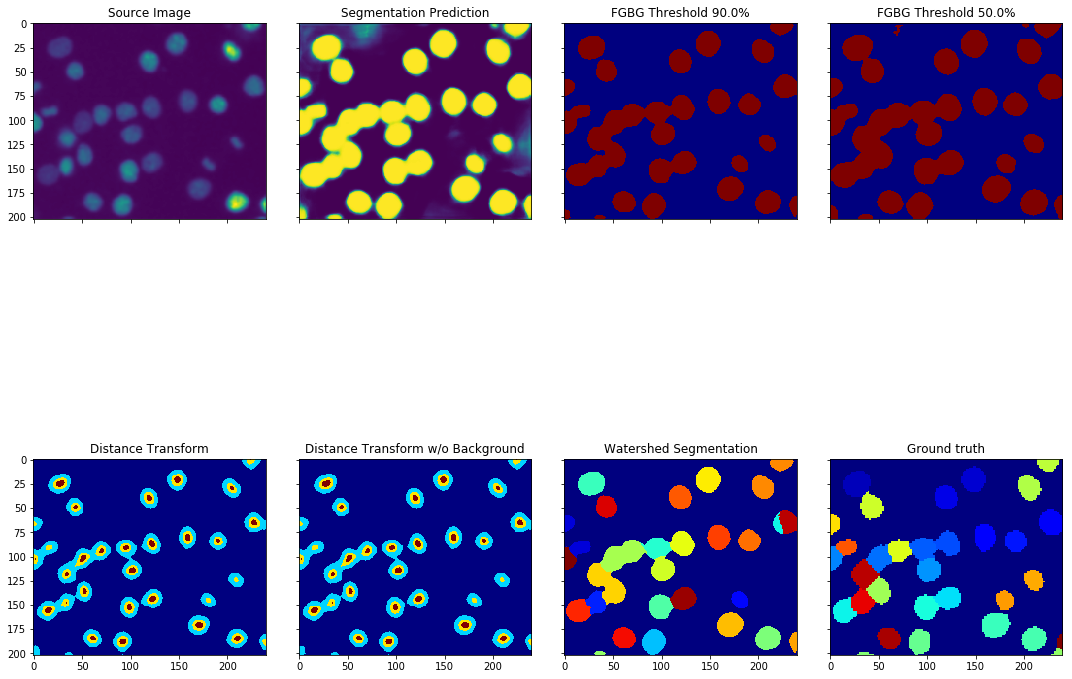

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 1 # np.random.randint(low=0, high=2)
frame = 25 # np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)



fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.5
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.5 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Make Predictions on ISBI Data for Metrics

In [ ]:
###### FOR ISBI Challenge Datasets

# Define data to load (raw images from trk test files)  
RAW_BASE_DIR = '/data/data/ISBI_Tracking_Challenge/tracks'

raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'ISBI_HeLa_Chal_GT.trks')
raw_trks_MSC  = os.path.join(RAW_BASE_DIR, 'ISBI_MSC_resized_Chal_GT_normalized.trks')
raw_trks_U373 = os.path.join(RAW_BASE_DIR, 'ISBI_U373_Chal_GT.trks')

#raw_trks_files = [raw_trks_HeLa, raw_trks_MSC, raw_trks_U373]
raw_trks_files = [raw_trks_HeLa]

# Define where segmentations will be saved
SEG_BASE_DIR = '/data/track_data/Final_Benchmarks/ISBI_DC_SEG/Watershed/HeLa_segmentations'
                             
DC_seg_HeLa  = os.path.join(SEG_BASE_DIR, 'HeLa/')
DC_seg_MSC   = os.path.join(SEG_BASE_DIR, 'MSC/')
DC_seg_U373  = os.path.join(SEG_BASE_DIR, 'U373/')

#DC_seg_folders = [DC_seg_HeLa, DC_seg_MSC, DC_seg_U373]
DC_seg_folders = [DC_seg_HeLa]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [ ]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')


watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(None, None, 1))

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

In [ ]:
# Run Predict for metric information only

CELL_TYPE_NAME = ['HeLa']
threshold = 0.9

from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import tarfile
import pathlib
import tempfile
import json
import pandas as pd
from io import BytesIO


def load_trks(filename):
    """Load a trk/trks file.

    Args:
        trks_file: full path to the file including .trk/.trks

    Returns:
        A dictionary with raw, tracked, and lineage data
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

    return {'X': raw, 'y': tracked}


Lstats_AllDatasets = []

# Go through each Dataset
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    raw, tracked = trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
                
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        # Predict on the raw data
        for frame_num, frame in enumerate(movie):
            
            image = np.expand_dims(frame, axis=0)
             
            test_image = watershed_model.predict(image)[-1]
            test_image_fgbg = fgbg_model.predict(image)[-1]

            # Postprocessing
            # Collapse predictions into semantic segmentation mask        
            max_image = np.argmax(test_image, axis=-1)
            argmax_image = np.expand_dims(max_image, axis=-1)
        
            # threshold the foreground/background
            # and remove background from watershed transform
            fg_thresh = test_image_fgbg[..., 1] > threshold

            fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
            argmax_image_post_fgbg = argmax_image * fg_thresh
        
            # Apply watershed method with the distance transform as seed
            image = fg_thresh[..., 0]
            distance = argmax_image_post_fgbg[..., 0]

            local_maxi = peak_local_max(test_image[..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_image = np.expand_dims(segments, axis=-1)
            
            # Remove small objects from GT for comparison
            small_objects_threshold=50
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            y_new[batch_num, frame_num, :, :, :] = watershed_image

            Lstats.append(m.stats)
            
    # Save results of this batch before moving on to the next
    filename = os.path.join(DC_seg_folders[set_num], 'all_batches.trks')
    filename = pathlib.Path(filename)

    with tarfile.open(str(filename), 'w') as trks:
        with tempfile.NamedTemporaryFile() as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            trks.add(raw_file.name, 'raw.npy')

        with tempfile.NamedTemporaryFile() as tracked_file:
            np.save(tracked_file, y_new)
            tracked_file.flush()
            trks.add(tracked_file.name, 'tracked.npy')
                
        
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)
    
    
#df_HeLa   = pd.concat(Lstats_AllDatasets[0])
df_HeLa = pd.concat([pd.concat(Lstats_AllDatasets[0][0]) , pd.concat(Lstats_AllDatasets[0][1])])


In [ ]:
CELL_TYPE_DF = [df_HeLa]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)